<a href="https://colab.research.google.com/github/MLRG-CEFET-RJ/attention-mechanism/blob/main/TemperatureSelfAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests, zipfile, io
from numpy import array
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os
import gc


Baixar o arquivo com o conjunto de dados.

In [2]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Carregar o arquivo (em formato CSV) para um objeto

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')

Visualização dos dados

In [4]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Preparação dos dados (converter a frequência de observações de 10 min para 1 hora)

In [5]:
print(df.shape)

# slice [start:stop:step], starting from index 5, take every 6th record.
df = df[5::6]

print(df.shape)

(420551, 15)
(70091, 15)


In [6]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

Sumário estatístico da temperatura

In [7]:
temperature = df['T (degC)']
temperature.describe()

count    70091.000000
mean         9.450482
std          8.423384
min        -22.760000
25%          3.350000
50%          9.410000
75%         15.480000
max         37.280000
Name: T (degC), dtype: float64

Iremos usar 1200 exemplos para treinar o modelo e 500 exemplos, tanto para validação quanto para teste.

In [8]:
train_set = temperature[:1200]
valid_set = temperature[69000:69500]
test_set = temperature[69500:]
print('Proporção de exemplos para treino: {:.2f}%'.format(len(train_set)/len(temperature)))
print('Proporção de exemplos para validação: {:.2f}%'.format(len(valid_set)/len(temperature)))
print('Proporção de exemplos para teste: {:.2f}%'.format(len(valid_set)/len(temperature)))

Proporção de exemplos para treino: 0.02%
Proporção de exemplos para validação: 0.01%
Proporção de exemplos para teste: 0.01%


Janelas deslizantes

In [9]:
def window_generator(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [10]:
n_steps = 3
train_x, train_y = window_generator(train_set.values, n_steps)
valid_x, valid_y = window_generator(valid_set.values, n_steps)
test_x, test_y = window_generator(test_set.values, n_steps)

In [11]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads):
    super().__init__()
    self.k, self.heads = k, heads

    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues  = nn.Linear(k, k * heads, bias=False)   
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
      b, t, k = x.size()
      h = self.heads

      queries = self.toqueries(x).view(b, t, h, k)
      keys    = self.tokeys(x)   .view(b, t, h, k)
      values  = self.tovalues(x) .view(b, t, h, k)


      keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
      queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
      values = values.transpose(1, 2).contiguous().view(b * h, t, k)


      queries = queries / (k ** (1/2))
      keys    = keys / (k ** (1/2))

      # - get dot product of queries and keys, and scale
      dot = torch.bmm(queries, keys.transpose(1, 2))
      # - dot has size (b*h, t, t) containing raw weights

      dot = F.softmax(dot, dim=2) 
      # - dot now contains row-wise normalized weights

      out = torch.bmm(dot, values).view(b, h, t, k)

      out = out.transpose(1, 2).contiguous().view(b, t, h * k)
      return self.unifyheads(out)



In [12]:
results = {}

In [13]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [14]:
n_epochs = 30
batch_size = 32

In [15]:
class Dataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        item = torch.as_tensor(item, dtype = torch.float32)
        label = torch.as_tensor(label, dtype = torch.float32)
        return item, label

train_ds = Dataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1), train_y)
valid_ds = Dataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1), valid_y)
test_ds = Dataset(test_x.reshape(test_x.shape[0],test_x.shape[1],1), test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 1, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size = 1, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = 1, shuffle = False)

In [16]:
dataset = Dataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
print(dataset.__getitem__(0))

(tensor([[-8.0500],
        [-8.8800],
        [-8.8100]]), tensor(-9.0500))


In [17]:
def train_model(model, batch_size, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

In [18]:
def predict (model):
  model.eval()  # prepare model for evaluation
  sum = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output,target)
          sum += loss.item()


  return (sum/len(test_loader))
 

In [19]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = Net1().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [20]:
model1, train_loss, valid_loss = train_model(model1, batch_size, n_epochs)
results["Test " + str(model1) + "MSELoss: "] = predict(model1)

[ 1/30] train_loss: 31.12170 valid_loss: 41.62337
[ 2/30] train_loss: 30.66393 valid_loss: 41.85033
[ 3/30] train_loss: 30.10756 valid_loss: 42.04209
[ 4/30] train_loss: 29.40699 valid_loss: 42.14557
[ 5/30] train_loss: 28.57475 valid_loss: 42.12058
[ 6/30] train_loss: 27.59555 valid_loss: 41.92150
[ 7/30] train_loss: 26.46112 valid_loss: 41.53049
[ 8/30] train_loss: 25.17387 valid_loss: 40.93110
[ 9/30] train_loss: 23.73233 valid_loss: 40.10346
[10/30] train_loss: 22.14084 valid_loss: 39.05220
[11/30] train_loss: 20.40900 valid_loss: 37.78384
[12/30] train_loss: 18.55794 valid_loss: 36.28725
[13/30] train_loss: 16.63014 valid_loss: 34.59451
[14/30] train_loss: 14.68566 valid_loss: 32.81500
[15/30] train_loss: 12.77013 valid_loss: 30.96900
[16/30] train_loss: 10.93215 valid_loss: 29.08394
[17/30] train_loss: 9.21842 valid_loss: 27.21188
[18/30] train_loss: 7.67335 valid_loss: 25.34808
[19/30] train_loss: 6.32754 valid_loss: 23.44706
[20/30] train_loss: 5.19308 valid_loss: 21.61463
[21/

In [21]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = Net2().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [22]:
model2, train_loss, valid_loss = train_model(model2, batch_size, n_epochs)
results["Test " + str(model2) + "MSELoss: "] = predict(model2)

[ 1/30] train_loss: 31.04564 valid_loss: 41.44039
[ 2/30] train_loss: 30.94705 valid_loss: 41.57525
[ 3/30] train_loss: 30.83620 valid_loss: 41.71384
[ 4/30] train_loss: 30.72433 valid_loss: 41.85569
[ 5/30] train_loss: 30.61202 valid_loss: 42.00007
[ 6/30] train_loss: 30.49977 valid_loss: 42.14672
[ 7/30] train_loss: 30.38777 valid_loss: 42.29556
[ 8/30] train_loss: 30.27606 valid_loss: 42.44660
[ 9/30] train_loss: 30.16507 valid_loss: 42.59906
[10/30] train_loss: 30.05435 valid_loss: 42.75482
[11/30] train_loss: 29.94354 valid_loss: 42.91278
[12/30] train_loss: 29.83296 valid_loss: 43.07373
[13/30] train_loss: 29.72296 valid_loss: 43.23665
[14/30] train_loss: 29.61292 valid_loss: 43.40340
[15/30] train_loss: 29.50250 valid_loss: 43.57376
[16/30] train_loss: 29.39195 valid_loss: 43.74767
[17/30] train_loss: 29.28117 valid_loss: 43.92587
[18/30] train_loss: 29.16976 valid_loss: 44.10871
[19/30] train_loss: 29.05793 valid_loss: 44.29589
[20/30] train_loss: 28.94591 valid_loss: 44.48723


In [23]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model3 = Net3().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [24]:
model3, train_loss, valid_loss = train_model(model3, batch_size, n_epochs)
results["Test " + str(model3) + "MSELoss: "] = predict(model3)

[ 1/30] train_loss: 35.78819 valid_loss: 36.99070
[ 2/30] train_loss: 32.50687 valid_loss: 34.71549
[ 3/30] train_loss: 28.82403 valid_loss: 32.19829
[ 4/30] train_loss: 25.35868 valid_loss: 29.50883
[ 5/30] train_loss: 22.09552 valid_loss: 26.63399
[ 6/30] train_loss: 18.79954 valid_loss: 23.59162
[ 7/30] train_loss: 15.50594 valid_loss: 20.36158
[ 8/30] train_loss: 12.02423 valid_loss: 17.04525
[ 9/30] train_loss: 8.90690 valid_loss: 13.79926
[10/30] train_loss: 6.34180 valid_loss: 10.76695
[11/30] train_loss: 4.52472 valid_loss: 8.19036
[12/30] train_loss: 3.60350 valid_loss: 6.22063
[13/30] train_loss: 3.28547 valid_loss: 4.79300
[14/30] train_loss: 3.12395 valid_loss: 3.77691
[15/30] train_loss: 2.99112 valid_loss: 3.08804
[16/30] train_loss: 2.88104 valid_loss: 2.65758
[17/30] train_loss: 2.78731 valid_loss: 2.40019
[18/30] train_loss: 2.70428 valid_loss: 2.24509
[19/30] train_loss: 2.62878 valid_loss: 2.14770
[20/30] train_loss: 2.56221 valid_loss: 2.07987
[21/30] train_loss: 2.

In [25]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model4 = Net4().to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [26]:
#model4, train_loss, valid_loss = train_model(model4, batch_size, n_epochs)
#results["Test " + str(model4) + "MSELoss: "] = predict(model4)

In [27]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model5 = Net5().to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [28]:
model5, train_loss, valid_loss = train_model(model5, batch_size, n_epochs)
results["Test " + str(model5) + "MSELoss: "] = predict(model5)

[ 1/30] train_loss: 31.76264 valid_loss: 40.64207
[ 2/30] train_loss: 31.58943 valid_loss: 40.89077
[ 3/30] train_loss: 31.34055 valid_loss: 41.20448
[ 4/30] train_loss: 31.05451 valid_loss: 41.56246
[ 5/30] train_loss: 30.75751 valid_loss: 41.92857
[ 6/30] train_loss: 30.46180 valid_loss: 42.33162
[ 7/30] train_loss: 30.14571 valid_loss: 42.78951
[ 8/30] train_loss: 29.80050 valid_loss: 43.31602
[ 9/30] train_loss: 29.43127 valid_loss: 43.90978
[10/30] train_loss: 29.04449 valid_loss: 44.56874
[11/30] train_loss: 28.65018 valid_loss: 45.28586
[12/30] train_loss: 28.25714 valid_loss: 46.05451
[13/30] train_loss: 27.87328 valid_loss: 46.86638
[14/30] train_loss: 27.50560 valid_loss: 47.71181
[15/30] train_loss: 27.15991 valid_loss: 48.58005
[16/30] train_loss: 26.84052 valid_loss: 49.45987
[17/30] train_loss: 26.54947 valid_loss: 50.32432
[18/30] train_loss: 26.29276 valid_loss: 51.21058
[19/30] train_loss: 26.06126 valid_loss: 52.06083
[20/30] train_loss: 25.86163 valid_loss: 52.88225


In [29]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model6 = Net6().to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [30]:
model6, train_loss, valid_loss = train_model(model6, batch_size, n_epochs)
results["Test " + str(model6) + "MSELoss: "] = predict(model6)

[ 1/30] train_loss: 29.73259 valid_loss: 41.98274
[ 2/30] train_loss: 28.10916 valid_loss: 42.88148
[ 3/30] train_loss: 26.36667 valid_loss: 43.23866
[ 4/30] train_loss: 24.63957 valid_loss: 43.00058
[ 5/30] train_loss: 22.88098 valid_loss: 42.10539
[ 6/30] train_loss: 21.03868 valid_loss: 40.70429
[ 7/30] train_loss: 19.10867 valid_loss: 38.95942
[ 8/30] train_loss: 17.08244 valid_loss: 36.92016
[ 9/30] train_loss: 14.99898 valid_loss: 34.64155
[10/30] train_loss: 12.91838 valid_loss: 32.27393
[11/30] train_loss: 10.91114 valid_loss: 29.86145
[12/30] train_loss: 9.04815 valid_loss: 27.47451
[13/30] train_loss: 7.42354 valid_loss: 25.15768
[14/30] train_loss: 6.08387 valid_loss: 22.88194
[15/30] train_loss: 5.06589 valid_loss: 20.74921
[16/30] train_loss: 4.35999 valid_loss: 18.84835
[17/30] train_loss: 3.90089 valid_loss: 17.17756
[18/30] train_loss: 3.60825 valid_loss: 15.73002
[19/30] train_loss: 3.40864 valid_loss: 14.49079
[20/30] train_loss: 3.26990 valid_loss: 13.41846
[21/30] t

In [31]:
class Net7(nn.Module):
    def __init__(self):
        super(Net7,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model7 = Net7().to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [32]:
model7, train_loss, valid_loss = train_model(model7, batch_size, n_epochs)
results["Test " + str(model7) + "MSELoss: "] = predict(model7)

[ 1/30] train_loss: 30.60919 valid_loss: 41.97938
[ 2/30] train_loss: 30.52351 valid_loss: 42.10328
[ 3/30] train_loss: 30.42892 valid_loss: 42.22887
[ 4/30] train_loss: 30.33382 valid_loss: 42.35658
[ 5/30] train_loss: 30.23944 valid_loss: 42.48397
[ 6/30] train_loss: 30.14621 valid_loss: 42.61239
[ 7/30] train_loss: 30.05351 valid_loss: 42.74301
[ 8/30] train_loss: 29.95987 valid_loss: 42.87750
[ 9/30] train_loss: 29.86488 valid_loss: 43.01612
[10/30] train_loss: 29.76852 valid_loss: 43.15902
[11/30] train_loss: 29.67084 valid_loss: 43.30630
[12/30] train_loss: 29.57167 valid_loss: 43.45868
[13/30] train_loss: 29.47086 valid_loss: 43.61608
[14/30] train_loss: 29.36876 valid_loss: 43.77816
[15/30] train_loss: 29.26565 valid_loss: 43.94473
[16/30] train_loss: 29.16173 valid_loss: 44.11570
[17/30] train_loss: 29.05770 valid_loss: 44.28912
[18/30] train_loss: 28.95373 valid_loss: 44.46681
[19/30] train_loss: 28.84938 valid_loss: 44.64861
[20/30] train_loss: 28.74484 valid_loss: 44.83436


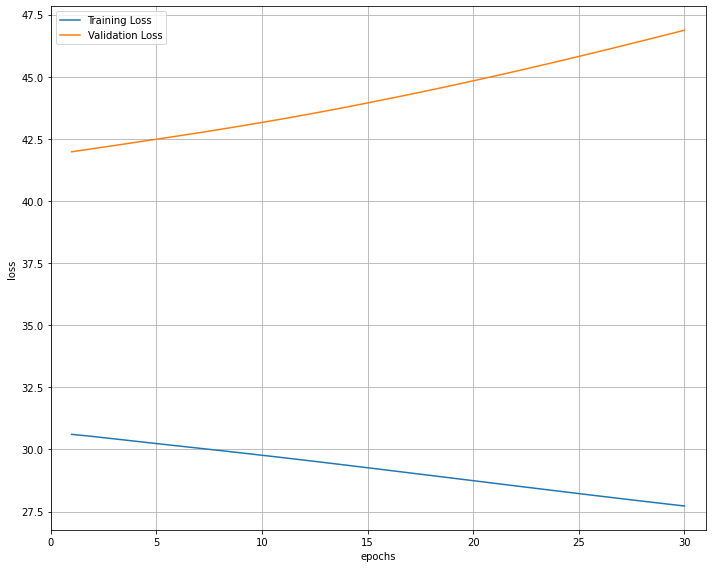

In [33]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [34]:
i = 0
for batch, (x, y) in enumerate(test_loader, 1):
  i = i + 1
  print(x[0].numpy())
  print(y.numpy())
  print(model7(x))
  if i > 10:
    break
  print()

[[-8.01]
 [-6.62]
 [-4.85]]
[-2.24]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[-6.62]
 [-4.85]
 [-2.24]]
[0.29]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[-4.85]
 [-2.24]
 [ 0.29]]
[0.08]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[-2.24]
 [ 0.29]
 [ 0.08]]
[1.]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[0.29]
 [0.08]
 [1.  ]]
[1.1]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[0.08]
 [1.  ]
 [1.1 ]]
[1.31]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[1.  ]
 [1.1 ]
 [1.31]]
[1.24]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[1.1 ]
 [1.31]
 [1.24]]
[1.06]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[1.31]
 [1.24]
 [1.06]]
[1.66]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[1.24]
 [1.06]
 [1.66]]
[1.52]
tensor([-0.8742], grad_fn=<AddBackward0>)

[[1.06]
 [1.66]
 [1.52]]
[1.49]
tensor([-0.8742], grad_fn=<AddBackward0>)


In [35]:
#nets = [Net1(), Net2(), Net3(), Net4(), Net5(), Net6(), Net7()]

#for n in nets:
  #model = n.to(device)
  #print(model)
  #model, train_loss, valid_loss = train_model(model, batch_size, n_epochs)
  #results["Test " + str(n) + "MSELoss: "] = predict(model)


In [36]:


for x in results:
  print(x,':',results[x])

Test Net1(
  (layer1): Sequential(
    (0): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
    (1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  )
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)MSELoss:  : 4.961216407561811
Test Net2(
  (layer1): Sequential(
    (0): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
    (1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (2): SelfAttention(
      (toke